In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import torch
from torch import nn

In [ ]:
### 1000 samples
n_samples = 1000
### creating dataset with added noise
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

In [ ]:
circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


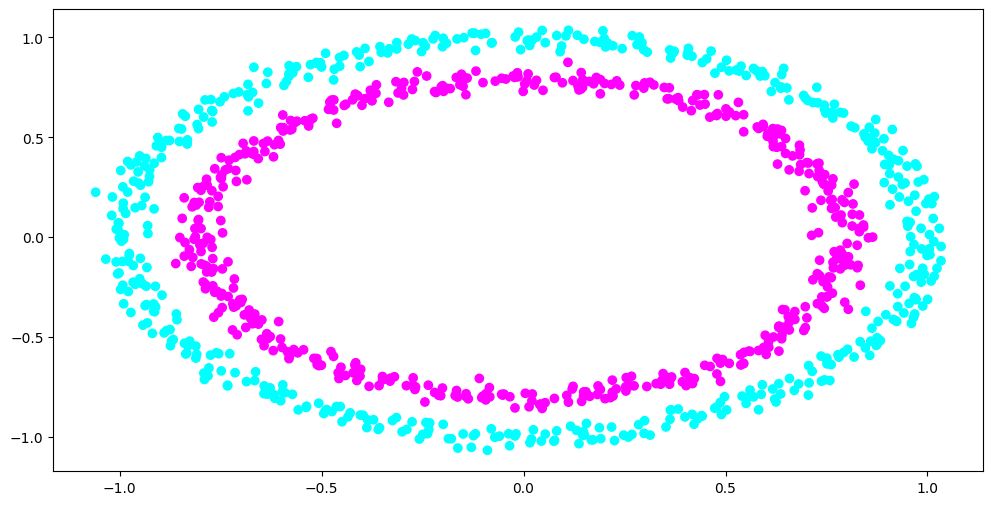

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap='cool')
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
## accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## `Introducing non-linearity`

In [ ]:
X[:5] , y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

`Building a non-linear model`

In [ ]:
class CircleNonLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
      ## layer3 -> relu -> layer2 -> relu -> layer1

model = CircleNonLinearModel().to(device)
model

CircleNonLinearModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
## loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)

### `training model with non-linearity`

In [ ]:
torch.manual_seed(89)
# torch.cuda.maual_seed(89)

## put all the data in device(device agnostic)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000
for epoch in range(epochs):
  model.train()
  ## forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) ## ;logits -> probabilities -> prediction labels
  ## loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,y_pred = y_pred)
  ## optimizer
  optimizer.zero_grad()
  loss.backward()  ## back prop
  optimizer.step() ## gradient descent
## testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70253 | Acc: 50.00% | Test Loss: 0.70196 | Test Acc: 50.00%
Epoch: 100 | Loss: 0.68981 | Acc: 61.62% | Test Loss: 0.69019 | Test Acc: 60.50%
Epoch: 200 | Loss: 0.68793 | Acc: 60.75% | Test Loss: 0.68869 | Test Acc: 61.50%
Epoch: 300 | Loss: 0.68548 | Acc: 60.75% | Test Loss: 0.68664 | Test Acc: 63.00%
Epoch: 400 | Loss: 0.68174 | Acc: 62.50% | Test Loss: 0.68388 | Test Acc: 63.50%
Epoch: 500 | Loss: 0.67512 | Acc: 65.25% | Test Loss: 0.67880 | Test Acc: 66.50%
Epoch: 600 | Loss: 0.66438 | Acc: 68.75% | Test Loss: 0.67069 | Test Acc: 70.00%
Epoch: 700 | Loss: 0.64662 | Acc: 75.38% | Test Loss: 0.65758 | Test Acc: 71.00%
Epoch: 800 | Loss: 0.61319 | Acc: 81.88% | Test Loss: 0.63108 | Test Acc: 75.00%
Epoch: 900 | Loss: 0.54491 | Acc: 94.75% | Test Loss: 0.57137 | Test Acc: 86.50%


In [ ]:
model.eval()
with torch.inference_mode():
  y_logits = model(X_test).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
y_pred[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

In [ ]:
y_test[:10] == y_pred[:10]

tensor([True, True, True, True, True, True, True, True, True, True])

`Replicating Non-Linear Model`

In [ ]:
A = torch.arange(-10., 10., 1)
A.dtype

torch.float32

In [ ]:
A[:5]

tensor([-10.,  -9.,  -8.,  -7.,  -6.])

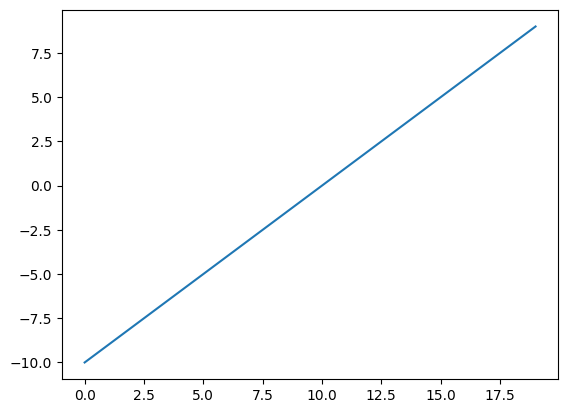

In [ ]:
plt.plot(A)
plt.show()

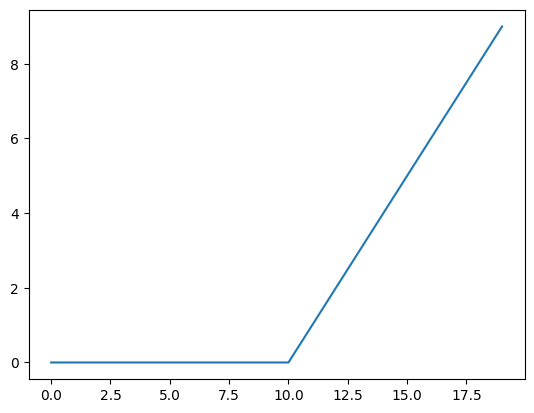

In [ ]:
plt.plot(torch.relu(A));

## `Custom ReLU function`

In [ ]:
def reLU(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

reLU(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

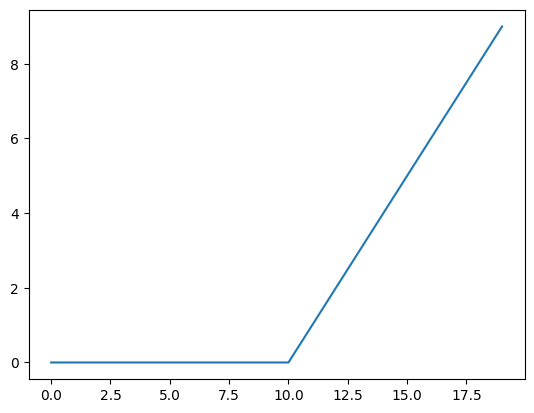

In [ ]:
plt.plot(reLU(A));

## `Custom Sigmoid`

In [ ]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

### `PyTorch's Sigmoid Function`

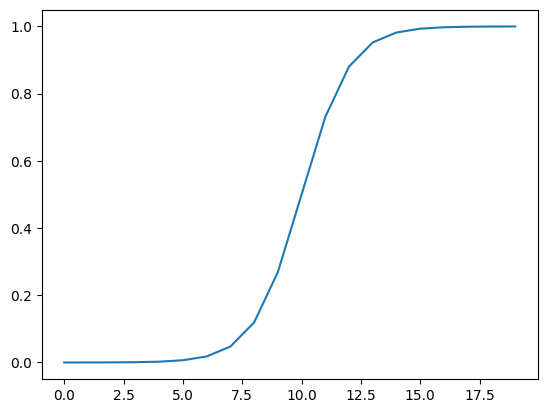

In [ ]:
plt.plot(torch.sigmoid(A));

## `Custom Sigmoid Function`

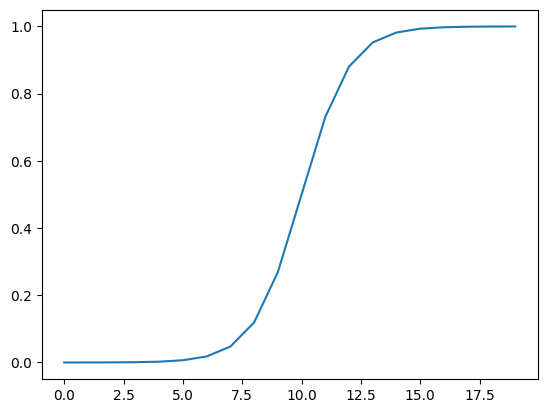

In [ ]:
plt.plot(sigmoid(A));

## `Multi-class Classification Problem`

- `Creating a multi-class classification data`

In [ ]:
from sklearn.datasets import make_blobs

In [ ]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDON_SEED = 42
SAMPLES = 1000

X_blob, y_blob = make_blobs(n_samples=SAMPLES, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDON_SEED)

In [ ]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
## spliting
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)

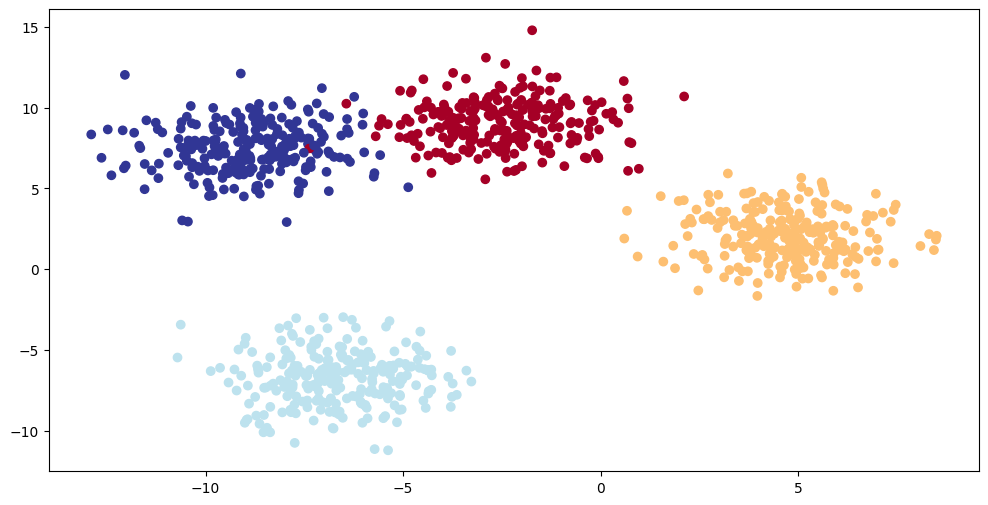

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

## `Multi-class classification model`

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" ## device agnostic
device

'cpu'

In [ ]:
class Multiclass(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    ## number of input features, output features, hidden units
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear(x)

model_multi = Multiclass(input_features = 2,
                         output_features = 4,
                         hidden_units = 8).to(device)

model_multi

Multiclass(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_multi.parameters(), lr=0.1)

In [ ]:
next(model_multi.parameters()).device

device(type='cpu')

In [ ]:
model_multi.eval()
with torch.inference_mode():
  y_logits = model_multi(X_blob_test.to(device))

In [ ]:
y_logits[:5]

tensor([[-0.1768, -0.1440, -0.2308,  0.4467],
        [ 0.3287, -0.2664, -0.4270,  0.0656],
        [ 1.2745,  0.1700, -0.5004, -0.5920],
        [-0.2850, -0.1640, -0.2484,  0.3650],
        [ 0.1981, -0.3360, -0.2714,  0.2533]])

In [ ]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [ ]:
## convert our model's logit outputs to prediction probabilities

y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.2064, 0.2132, 0.1955, 0.3849],
        [0.3584, 0.1977, 0.1683, 0.2755],
        [0.6040, 0.2002, 0.1024, 0.0934],
        [0.1968, 0.2221, 0.2041, 0.3770],
        [0.3060, 0.1794, 0.1913, 0.3233]])

In [ ]:
print(f"Softmax Output:\n {y_pred_probs[:5]}\nLogits Output:\n {y_logits[:5]}")

Softmax Output:
 tensor([[0.2064, 0.2132, 0.1955, 0.3849],
        [0.3584, 0.1977, 0.1683, 0.2755],
        [0.6040, 0.2002, 0.1024, 0.0934],
        [0.1968, 0.2221, 0.2041, 0.3770],
        [0.3060, 0.1794, 0.1913, 0.3233]])
Logits Output:
 tensor([[-0.1768, -0.1440, -0.2308,  0.4467],
        [ 0.3287, -0.2664, -0.4270,  0.0656],
        [ 1.2745,  0.1700, -0.5004, -0.5920],
        [-0.2850, -0.1640, -0.2484,  0.3650],
        [ 0.1981, -0.3360, -0.2714,  0.2533]])


In [ ]:
torch.sum(y_pred_probs[0])

tensor(1.)

In [ ]:
torch.argmax(y_pred_probs[0])

tensor(3)

In [ ]:
## convert our model prediction probs to prediction labels
y_preds_multi = torch.argmax(y_pred_probs, dim=1)
y_preds_multi[:5]

tensor([3, 0, 0, 3, 3])

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
y_test[:5] == y_preds_multi[:5]

tensor([False,  True, False, False, False])

`Training and Testing Loop(multi-class model)`

In [ ]:
torch.manual_seed(98)
# torch.cuda.manual_seed(98)

epochs = 100

## data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_multi.train()
  ## forward pass
  y_logits = model_multi(X_blob_train).squeeze()
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  ## loss
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,y_pred = y_pred)
  ## optimizer
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ## testing
  model.eval()
  with torch.inference_mode():
    test_logits = model_multi(X_blob_test).squeeze()
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.30482 | Acc: 24.88% | Test Loss: 1.19323 | Test Acc: 24.50%
Epoch: 10 | Loss: 0.55252 | Acc: 97.75% | Test Loss: 0.46964 | Test Acc: 99.00%
Epoch: 20 | Loss: 0.19485 | Acc: 99.38% | Test Loss: 0.16238 | Test Acc: 99.50%
Epoch: 30 | Loss: 0.09467 | Acc: 99.25% | Test Loss: 0.07876 | Test Acc: 99.50%
Epoch: 40 | Loss: 0.06342 | Acc: 99.38% | Test Loss: 0.05132 | Test Acc: 99.50%
Epoch: 50 | Loss: 0.04968 | Acc: 99.38% | Test Loss: 0.03881 | Test Acc: 99.50%
Epoch: 60 | Loss: 0.04226 | Acc: 99.38% | Test Loss: 0.03188 | Test Acc: 99.50%
Epoch: 70 | Loss: 0.03768 | Acc: 99.50% | Test Loss: 0.02751 | Test Acc: 99.50%
Epoch: 80 | Loss: 0.03462 | Acc: 99.50% | Test Loss: 0.02451 | Test Acc: 99.50%
Epoch: 90 | Loss: 0.03232 | Acc: 99.38% | Test Loss: 0.02226 | Test Acc: 99.50%


In [ ]:
model.eval()
with torch.inference_mode():
  y_logits = model_multi(X_blob_test).squeeze()
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_pred[:5]

tensor([1, 3, 2, 1, 0])

In [ ]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [ ]:
y_blob_test[:10] == y_pred[:10]

tensor([True, True, True, True, True, True, True, True, True, True])

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

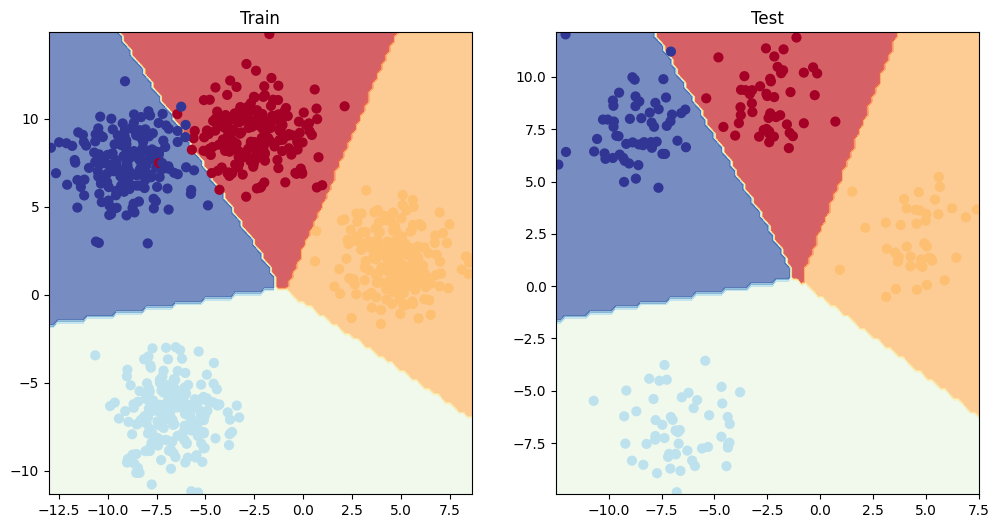

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_multi, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_multi, X_blob_test, y_blob_test)

- `Precision`
- `Recall`
- `Accuracy`
    - `(for balanced data)`
- `F1 Score`
- `Confusion Matrix`
- `Classification Report`

In [ ]:
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

In [ ]:
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4)
torchmetrics_precision = Precision(task="multiclass", num_classes=4)
torchmetrics_recall = Recall(task="multiclass", num_classes=4)
torchmetrics_f1 = F1Score(task="multiclass", num_classes=4)

In [ ]:
torchmetrics_accuracy(y_pred, y_blob_test)

tensor(0.9950)

In [ ]:
torchmetrics_precision(y_pred, y_blob_test)

tensor(0.9950)

In [ ]:
torchmetrics_recall(y_pred, y_blob_test)

tensor(0.9950)

In [ ]:
torchmetrics_f1(y_pred, y_blob_test)

tensor(0.9950)